In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import math
from concurrent.futures import ThreadPoolExecutor, as_completed

from aptos.data_loader import ImgProcessor

## PreProcess Images

In [3]:
DATA_DIR = Path('../data/raw/diabetic-retinopathy-detection')
TRAIN_DIR = DATA_DIR / 'resized_train_cropped'
TEST_DIR  = DATA_DIR / 'resized_test'

In [4]:
NWORKERS = 16
train_imgs = list(TRAIN_DIR.glob('*.jpeg'))
test_imgs = list(TEST_DIR.glob('*.jpg'))
print(len(train_imgs), len(test_imgs))

35108 53576


In [5]:
processor = ImgProcessor()

In [6]:
PROCESS_DIR = Path('../data/preprocessed/diabetic-retinopathy-detection')
PRO_TRAIN_DIR = PROCESS_DIR / 'train_images'
PRO_TRAIN_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(processor, str(f)): f for f in train_imgs}
    for future in tqdm(as_completed(results), total=len(train_imgs)):
        img = future.result()
        f = results[future]
        save_as = PRO_TRAIN_DIR / f.stem
        np.save(save_as, img)

100%|██████████| 35108/35108 [06:21<00:00, 92.14it/s] 


In [8]:
with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(processor, str(f)): f for f in test_imgs}
    for future in tqdm(as_completed(results), total=len(test_imgs)):
        img = future.result()
        f = results[future]
        save_as = PRO_TRAIN_DIR / f.stem
        np.save(save_as, img)

100%|██████████| 53576/53576 [09:12<00:00, 97.03it/s] 


## Wrangle labels data

Join the train and test sets together

In [9]:
train_labels_filename = '../data/raw/diabetic-retinopathy-detection/trainLabels_cropped.csv'
train_df = pd.read_csv(train_labels_filename)[['image', 'level']]
train_df.columns = ['id_code', 'diagnosis']
print(train_df.shape)
train_df.head(2)

(35108, 2)


,id_code,diagnosis
0,10_left,0
1,10_right,0


In [10]:
test_labels_filename = '../data/raw/diabetic-retinopathy-detection/testLabels.csv'
test_df = pd.read_csv(test_labels_filename)[['image', 'level']]
test_df.columns = ['id_code', 'diagnosis']
print(test_df.shape)
test_df.head(2)

(53576, 2)


,id_code,diagnosis
0,1_left,0
1,1_right,0


In [11]:
join_df = pd.concat([train_df, test_df], axis=0)
print(join_df.shape)
print(join_df.groupby('diagnosis').count())
join_df.head()

(88684, 2)
           id_code
diagnosis         
0            65335
1             6200
2            13149
3             2086
4             1914


,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [12]:
join_df.to_csv(PROCESS_DIR / 'train.csv', index=False)

## Check train examples

In [13]:
pro_train_imgs = list(PRO_TRAIN_DIR.glob('*.npy'))
print(len(pro_train_imgs))

88684


In [14]:
n_samples = 10
figsize = 8

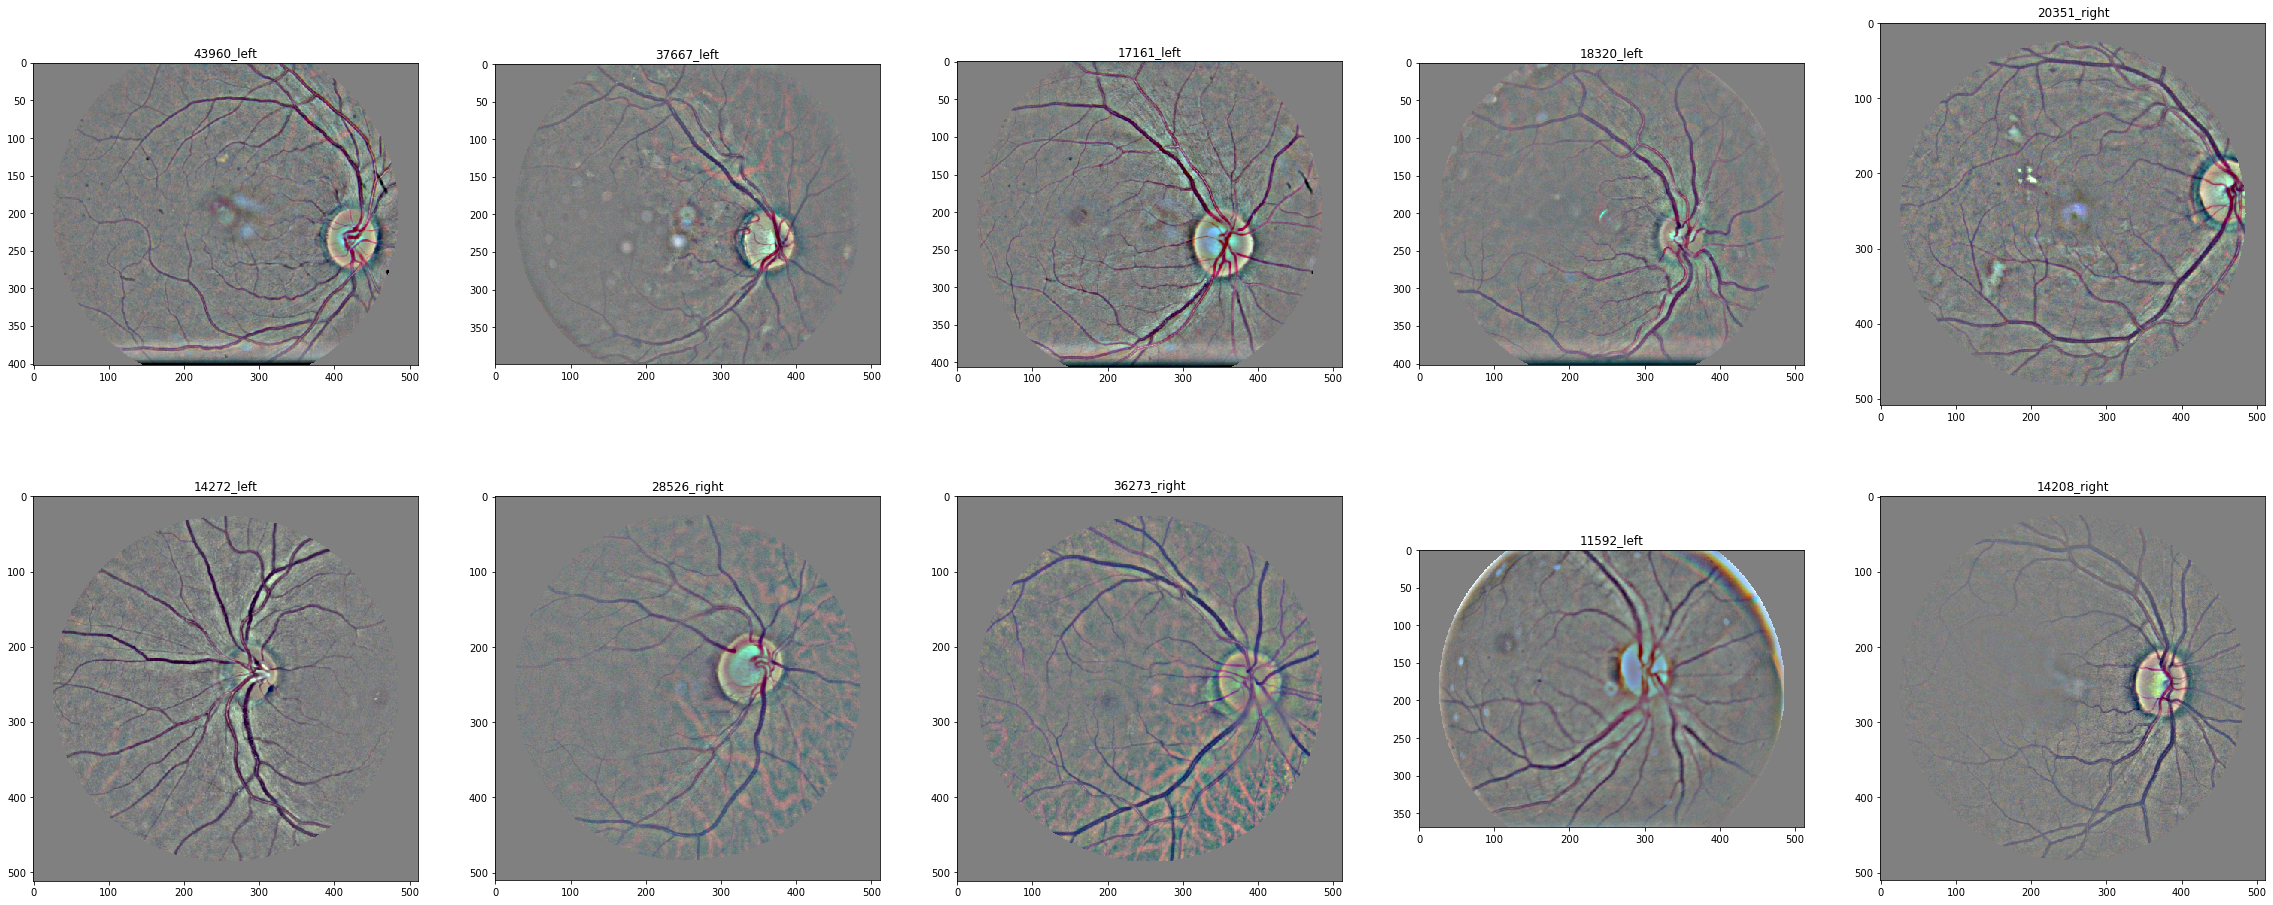

In [15]:
np.random.shuffle(pro_train_imgs)
fig, axs = plt.subplots(2, n_samples // 2, figsize=(40, 16))
for i in range(n_samples // 2):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[0, i].imshow(train_img)
    axs[0, i].set_title(pro_train_imgs[i].stem)
for i in range(n_samples // 2, n_samples):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[1, i - n_samples // 2].imshow(train_img)
    axs[1, i - n_samples // 2].set_title(pro_train_imgs[i].stem)